# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

The data (provided by Udacity) is kept in the local folder /signal_data/. It is already divided into training, validation and testing.

In [4]:
# Load pickled data
import pickle
from sklearn.utils import shuffle

# All images are 32x32, so no resizing is necessary

# Loading data provided by Udacity
training_file = 'sign_data/train.p'
validation_file='sign_data/valid.p'
testing_file = 'sign_data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Shuffling the training data
X_train, y_train = shuffle(X_train, y_train)

# Ensuring there are no issues with data sizes
assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))



---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Providing a Basic Summary of the Data Set Using Python and Numpy

In [5]:
# Information about the data set
n_train = len(X_train)
n_valid = len(X_valid)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = max(y_train)

print("\nPreprocessing:")
print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Preprocessing:
Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 42


### Include an exploratory visualization of the dataset

Here, I plot an example of each of the 43 different signs. I also plot a graph which shows how many of each sign are in the training set.

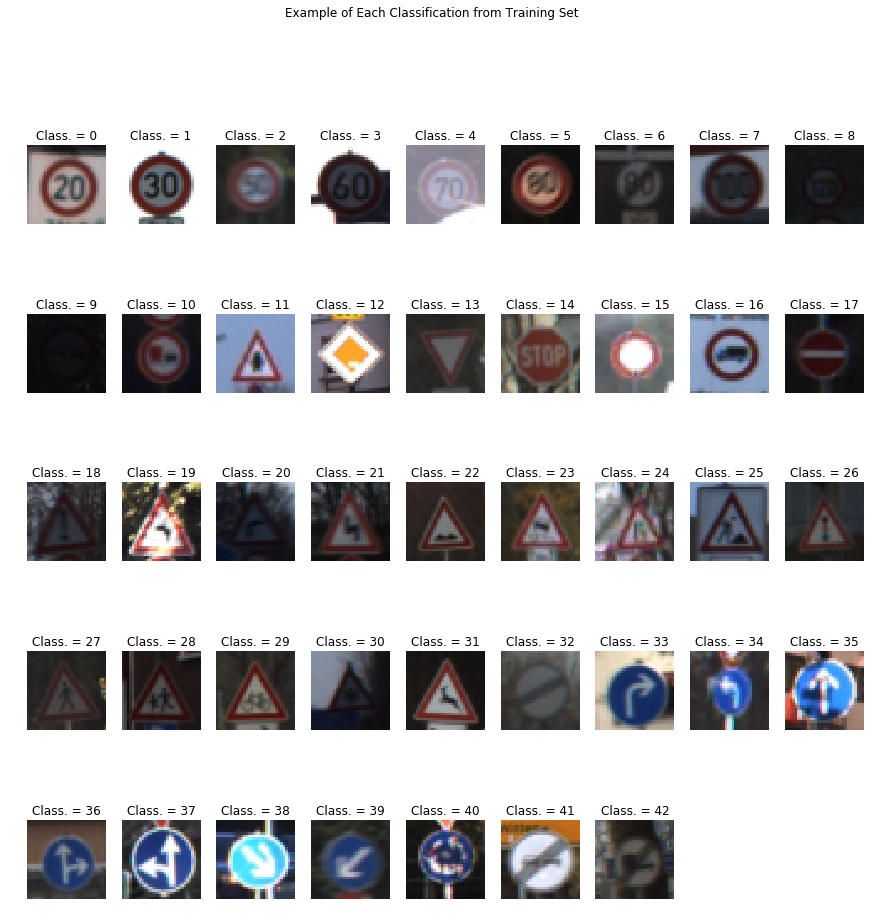

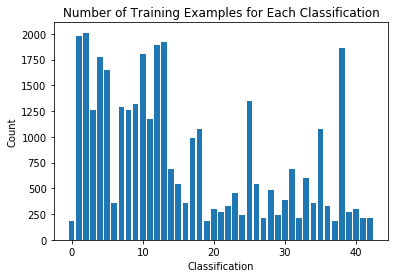

In [6]:
# Displaying a random sign from the training set, and printing its classification
import random
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

[classes, idx, counts] = np.unique(y_train, return_index=True, return_counts=True)

plt.figure(num=1,figsize=(15,15))
plt.suptitle('Example of Each Classification from Training Set')
for i in range(1,44):
    image = X_train[idx[i-1]].squeeze()
    plt.subplot(5,9, i) # sets the number of feature maps to show on each row and column
    plt.title('Class. = ' + str(i-1)) # displays the feature map number
    plt.axis('off')
    plt.imshow(image)
    
plt.figure(num=2)
plt.bar(classes, counts)
plt.ylabel('Count')
plt.xlabel('Classification')
plt.title('Number of Training Examples for Each Classification')
plt.show()


----

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set (normalization, grayscale, etc.)
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [7]:
### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.
### Feel free to use as many code cells as needed.
import numpy as np

def normalize(x):
    return x/127.5 - 1.0
    
def grayscale(rgb):
    
    r, g, b = rgb[:,:,:,0], rgb[:,:,:,1], rgb[:,:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    
    return np.expand_dims(gray, axis=-1)

# Normalizing data from (0,255) to (-1,1)
X_train = normalize(X_train)
X_valid = normalize(X_valid)
X_test = normalize(X_test)

# Converting to grayscale (Going from depth of 3 to 1)
X_train = grayscale(X_train)
X_valid = grayscale(X_valid)
X_test = grayscale(X_test)


### Model Architecture

My "inception" neural network is based off of the inception modules explained in the Udacity lessons on deep learning. It is also based on the archiceture outlined in this article (https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), albiet with some changes. 

The architecture features two inception modules, followed by two fully-connected layers. When training, the first fully-connected layer has dropout. The number of feature maps and the depths of the layers were reduced significantly, as their sizes were restricted by memory issues on the training computer.

The first inception module is as follows, with the input as 32x32x1 and the output concatenation 24 32x32 feature maps:    

* Input -> 1x1 convolution (6 32x32 feature maps) -> concatenation
* Input -> 1x1 convolution (3 32x32 feature maps) -> 3x3 convolution (6 32x32 feature maps) -> concatenation
* Input -> 1x1 convolution (3 32x32 feature maps) -> 5x5 convolution (6 32x32 feature maps) -> concatenation
* Input -> 3x3 max pooling (1 32x32 feature map) -> 1x1 convolution (6 32x32 feature maps) -> concatenation

The second is similar to the first with the input 24 32x32 feature maps from the previous module, and the output a flattened concatenation of 48 32x32 feature maps, resulting in a shape of 1x49152:
* Input -> 1x1 convolution (12 32x32 feature maps) -> flattened concatenation
* Input -> 1x1 convolution (3 32x32 feature maps) -> 3x3 convolution (12 32x32 feature maps) -> flattened concatenation
* Input -> 1x1 convolution (3 32x32 feature maps) -> 5x5 convolution (12 32x32 feature maps) -> flattened concatenation
* Input -> 3x3 max pooling (24 32x32 feature maps) -> 1x1 convolution (12 32x32 feature maps) -> flattened concatenation

Then the first fully connected layer, with the input the 1x49152 concatenation from the previous layer, and the output 1x128
* Input -> ReLU (with dropout for training)

Then the final layer, with a 1x128 input and a 1x43 output,
* Input -> output (logits)


In [8]:
def inception(x, drop):
    
    # Values for the random distribution of initial weights
    mu = 0
    sigma = 0.1

    # These parameters define the number of feature maps and the depth of the layers, and they are relatively 
    # small due to memory constraints on the training computer
    map1 = 6
    map2 = 12
    reduce1x1 = 3
    num_fc1 = 128
    num_fc2 = 43
    img_size = 32
    
    # This model follows loosely from the following article:
    # https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/

    # Both inception modules have the following components:
    # Input -> 1x1 convolution -> concatenation
    # Input -> 1x1 convolution -> 3x3 convolution -> concatenation
    # Input -> 1x1 convolution -> 5x5 convolution -> concatenation
    # Input -> 3x3 max pooling -> 1x1 convolution -> concatenation
    
    # Inception module 1
    W_conv1_1x1_1 = tf.Variable(tf.truncated_normal(shape=(1,1,1,map1), mean = mu, stddev = sigma))
    b_conv1_1x1_1 = tf.Variable(tf.zeros(map1))
     
    W_conv1_1x1_2 = tf.Variable(tf.truncated_normal(shape=(1,1,1,reduce1x1), mean = mu, stddev = sigma))
    b_conv1_1x1_2 = tf.Variable(tf.zeros(reduce1x1))
     
    W_conv1_1x1_3 = tf.Variable(tf.truncated_normal(shape=(1,1,1,reduce1x1), mean = mu, stddev = sigma))
    b_conv1_1x1_3 = tf.Variable(tf.zeros(reduce1x1))
     
    W_conv1_3x3 = tf.Variable(tf.truncated_normal(shape=(3,3,reduce1x1,map1), mean = mu, stddev = sigma))
    b_conv1_3x3 = tf.Variable(tf.zeros(map1))
     
    W_conv1_5x5 = tf.Variable(tf.truncated_normal(shape=(5,5,reduce1x1,map1), mean = mu, stddev = sigma))
    b_conv1_5x5 = tf.Variable(tf.zeros(map1))
     
    W_conv1_1x1_4= tf.Variable(tf.truncated_normal(shape=(1,1,1,map1), mean = mu, stddev = sigma))
    b_conv1_1x1_4= tf.Variable(tf.zeros(map1))
    
    conv1_1x1_1 = tf.nn.conv2d(x, W_conv1_1x1_1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1_1x1_1
    conv1_1x1_2 = tf.nn.relu(tf.nn.conv2d(x, W_conv1_1x1_2, strides=[1, 1, 1, 1], padding='SAME') + b_conv1_1x1_2)
    conv1_1x1_3 = tf.nn.relu(tf.nn.conv2d(x, W_conv1_1x1_3, strides=[1, 1, 1, 1], padding='SAME') + b_conv1_1x1_3)
    conv1_3x3 = tf.nn.conv2d(conv1_1x1_2, W_conv1_3x3, strides=[1, 1, 1, 1], padding='SAME') + b_conv1_3x3
    conv1_5x5 = tf.nn.conv2d(conv1_1x1_3, W_conv1_5x5, strides=[1, 1, 1, 1], padding='SAME') + b_conv1_5x5
    maxpool1 = tf.nn.max_pool(x,ksize=[1,3,3,1],strides=[1,1,1,1],padding='SAME')
    conv1_1x1_4 = tf.nn.relu(tf.nn.conv2d(maxpool1, W_conv1_1x1_4, strides=[1, 1, 1, 1], padding='SAME') + b_conv1_1x1_4)
        
    # Concatenation of all feature maps, with ReLU
    inception1 = tf.nn.relu(tf.concat([conv1_1x1_1,conv1_3x3,conv1_5x5,conv1_1x1_4],3), name='inception1')

    #Inception Module2
    W_conv2_1x1_1 = tf.Variable(tf.truncated_normal(shape=(1,1,4*map1,map2), mean = mu, stddev = sigma))
    b_conv2_1x1_1 = tf.Variable(tf.zeros(map2))
     
    W_conv2_1x1_2 = tf.Variable(tf.truncated_normal(shape=(1,1,4*map1,reduce1x1), mean = mu, stddev = sigma))
    b_conv2_1x1_2 = tf.Variable(tf.zeros(reduce1x1))
     
    W_conv2_1x1_3 = tf.Variable(tf.truncated_normal(shape=(1,1,4*map1,reduce1x1), mean = mu, stddev = sigma))
    b_conv2_1x1_3 = tf.Variable(tf.zeros(reduce1x1))
     
    W_conv2_3x3 = tf.Variable(tf.truncated_normal(shape=(3,3,reduce1x1,map2), mean = mu, stddev = sigma))
    b_conv2_3x3 = tf.Variable(tf.zeros(map2))
     
    W_conv2_5x5 = tf.Variable(tf.truncated_normal(shape=(5,5,reduce1x1,map2), mean = mu, stddev = sigma))
    b_conv2_5x5 = tf.Variable(tf.zeros(map2))
     
    W_conv2_1x1_4= tf.Variable(tf.truncated_normal(shape=(1,1,4*map1,map2), mean = mu, stddev = sigma))
    b_conv2_1x1_4= tf.Variable(tf.zeros(map2))
        
    conv2_1x1_1 = tf.nn.conv2d(inception1, W_conv2_1x1_1, strides=[1, 1, 1, 1], padding='SAME') + b_conv2_1x1_1
    conv2_1x1_2 = tf.nn.relu(tf.nn.conv2d(inception1, W_conv2_1x1_2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2_1x1_2)
    conv2_1x1_3 = tf.nn.relu(tf.nn.conv2d(inception1, W_conv2_1x1_3, strides=[1, 1, 1, 1], padding='SAME') + b_conv2_1x1_3)
    conv2_3x3 = tf.nn.conv2d(conv2_1x1_2, W_conv2_3x3, strides=[1, 1, 1, 1], padding='SAME') + b_conv2_3x3
    conv2_5x5 = tf.nn.conv2d(conv2_1x1_3, W_conv2_5x5, strides=[1, 1, 1, 1], padding='SAME') + b_conv2_5x5
    maxpool2 = tf.nn.max_pool(inception1,ksize=[1,3,3,1],strides=[1,1,1,1],padding='SAME')
    conv2_1x1_4 = tf.nn.relu(tf.nn.conv2d(maxpool2, W_conv2_1x1_4, strides=[1, 1, 1, 1], padding='SAME') + b_conv2_1x1_4)
        
    # Concatenation of all feature maps, with ReLU
    inception2 = tf.nn.relu(tf.concat([conv2_1x1_1,conv2_3x3,conv2_5x5,conv2_1x1_4],3), name='inception2')

    # Flattening
    inception2_flat = tf.reshape(inception2,[-1,img_size*img_size*4*map2])
       
    # These are the two fully connected layers, the first of which has dropout when training
    W_fc1 = tf.Variable(tf.truncated_normal(shape=(img_size*img_size*(4*map2),num_fc1), mean = mu, stddev = sigma))
    b_fc1 = tf.Variable(tf.zeros(num_fc1))
        
    h_fc1 =tf.nn.dropout(tf.nn.relu(tf.matmul(inception2_flat,W_fc1)+b_fc1),drop)

    W_fc2 = tf.Variable(tf.truncated_normal(shape=(num_fc1,num_fc2), mean = mu, stddev = sigma))
    b_fc2 = tf.Variable(tf.zeros(num_fc2))
    
    logits = tf.matmul(h_fc1, W_fc2) + b_fc2
    
    return logits

### Training and Validating the Model
Here, I train and validate the model. The batch size is set to 128. The epochs are set to 40. The dropout is set high at 0.5 to reduce overfitting.

In [6]:
import tensorflow as tf

EPOCHS = 40
BATCH_SIZE = 128

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
drop = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

rate = 0.001

logits = inception(x, drop)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

# Training, validating, testing and saving the model
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("\nTraining...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, drop: 0.5})
            
        train_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Train Accuracy = {:.3f}".format(train_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './incept')
    print("Model saved")


Training...



KeyboardInterrupt: 

### Testing the model
Here, I test the model on the test set provided by Udacity.

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
 
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

---

## Step 3: Test a Model on New Images

Here, we test eight images of German traffic signs taken from Wikipedia. They are resized manually to 32x32, to be compatible with the neural network. 

### Load and Output the Images

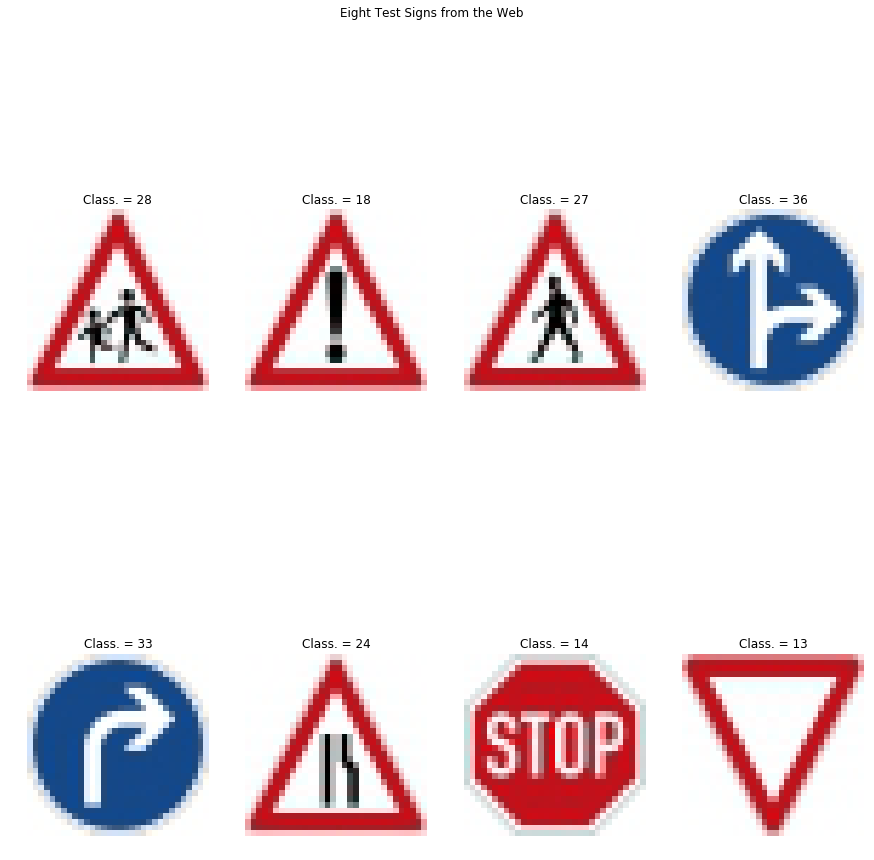

In [11]:
import os
import matplotlib.image as mpimg

strImageIn = ["outside_images/" + x for x in os.listdir("outside_images/")]
image_class = [28, 18, 27, 36, 33, 24, 14, 13]

plt.figure(num=3,figsize=(15,15))
plt.suptitle('Eight Test Signs from the Web')
for i in range(1,9):
    X_web = mpimg.imread(strImageIn[i-1])
    image = X_web.squeeze()
    plt.subplot(2,4, i) # sets the number of feature maps to show on each row and column
    plt.title('Class. = ' + str(image_class[i-1])) # displays the feature map number
    plt.axis('off')
    plt.imshow(image)

### Predict the Sign Type for Each Image

In [14]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    image_num = 0
    plt_num = 4
    successes = 0
    
    # Looping over the 8 images in the directory
    for image in strImageIn:
    
        # Reading them in and formatting the arrays correctly
        X_test_map_img = mpimg.imread(image)
        X_test_map = np.expand_dims(X_test_map_img, axis=0)
        
        # Normalizing data from (0,255) to (-1,1)
        X_test_map = normalize(X_test_map)
        
        # Converting to grayscale (Going from depth of 3 to 1)
        X_test_map = grayscale(X_test_map)
        
        # Finding the softmax probabilities
        logits2 = sess.run(testing_images, feed_dict={x: X_test_map, drop: 1.0})
        
        # Getting the top five softmax results
        topKV = sess.run(tf.nn.top_k(logits2, k=5))
        
        # Reformatting the above topKV data to make plotting easier
        classes = topKV[1].squeeze();
        softs = topKV[0].squeeze();
        idx = np.argsort(classes)
        
        # Printing the above data as requested by Udacity
        print('\nTest image ' + str(image_num) + ' (true classification: ' + str(image_class[image_num]) + ')')
        print('Top five softmaxes: ' + str(softs))
        print('Corresponding classifications: ' + str(classes))
        
        # Plotting bar graphs showing the top five softmax results for each of the 8 web images
        plt.figure(num=plt_num)
        plt.xticks(range(0,6), classes[idx])
        plt.bar(np.array(range(0,5)), softs[idx])
        plt.ylabel('Softmax')
        plt.xlabel('Neural Network Classification')
        plt.title('Top Five Softmax Probabilities for Test Image - True Classification: ' + str(image_class[image_num]))
        plt.show()
        
        # If we classified this web image correctly, we add it to a tally
        if classes[0] == image_class[image_num]:
            successes += 1
        
        image_num += 1
        plt_num += 1


NameError: name 'tf' is not defined

### Analyze Performance

In [4]:
    # Finding the accuracy over the web images
    web_image_accuracy = successes/8
    
    print('\nAccuracy over the images aquired on the web: ' + str(web_image_accuracy))

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [6]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    # Outputting feature maps for both inception layers on a test image to visualize
    outputFeatureMap(X_test_map, sess.graph.get_tensor_by_name('inception1:0'), activation_min=-1, activation_max=-1 ,plt_num=plt_num)
    outputFeatureMap(X_test_map, sess.graph.get_tensor_by_name('inception2:0'), activation_min=-1, activation_max=-1 ,plt_num=plt_num+1)

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 